In [78]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob
import scipy

In [3]:
def top_k(result, top_num, label_arr):
    tmp = -(top_num+1)
    top_k = result.flatten().argsort()[-1:tmp:-1]
    top_num = 1
    for i in np.arange(top_k.size):
        print("Top %d:\tProb:%2.4f%%\t[%d]\t %s"%(top_num,result[top_k[i]]*100,top_k[i], labels[top_k[i]]))
        top_num = top_num + 1

In [4]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [5]:
def read_dimg(dimg_file):
    return np.genfromtxt(dimg_file, float, delimiter=' ')

In [6]:
def get_image_path(basename,path,ext):
    return(path + os.path.basename(basename).split('.')[0] + ext)

In [7]:
def loss_rate(arr1, arr2):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(arr1,arr2)))/len(arr1)

In [8]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

In [33]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('on')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [9]:
def caffe_inference(image_path):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_5_17/sw/prebuilt/linux/model/'
    input_file = image_path
    model_def = os.path.join(model_dir,"cifar10/cifar_quick_conv.prototxt")
    pretrained_model = os.path.join(model_dir,"cifar10/cifar10_quick_iter_4000.caffemodel")
    gpu = False
    center_only = True
    images_dim = '32,32'
    mean_file = '/home/caslab/workspace/caffe/caffe/examples/cifar10/mean.npy'
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    
    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=None,
    #         image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)


    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]
    load_img_time_end = time.time()

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

In [39]:
dimg_root_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/test/'
dimg_files = read_files(dimg_root_path,'dimg')
image_root_path = '/home/caslab/workspace/dataset/cifar/mix/'

element = dimg_files[1]

test_name = (os.path.basename(element).split('.')[0])
nvdla_result = (read_dimg(element))
caffe_result = (caffe_inference(get_image_path(element,image_root_path,'.jpg')))

nvdla_feature_map = nvdla_result.reshape(32,32,-1)


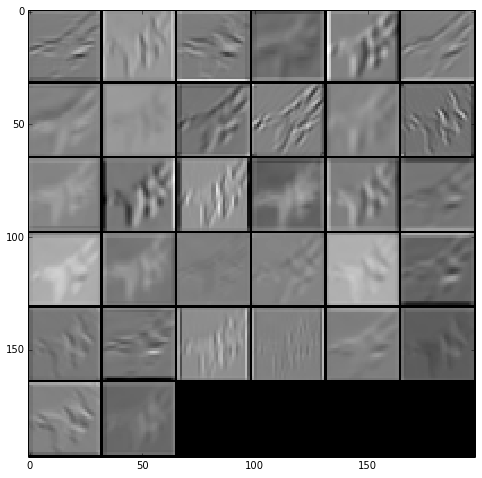

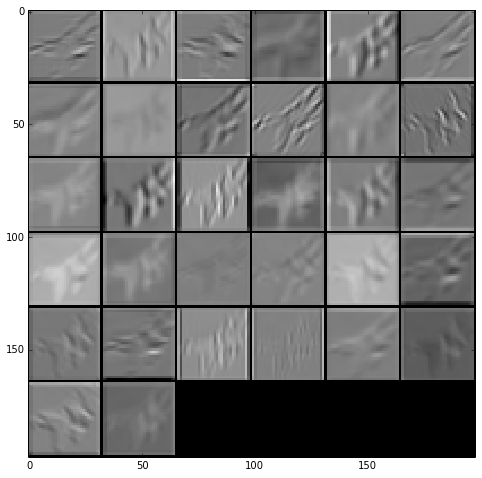

In [40]:
show_data(caffe_result)
show_data(nvdla_feature_map)

In [79]:
nvdla_flatten = nvdla_feature_map.reshape(-1)
caffe_flatten = caffe_result.reshape(-1)
print ("Loss rate (Absolute loss function): %f"%loss_rate(nvdla_flatten,caffe_flatten))
print ("Cross Entropy: %f"%cross_entropy(nvdla_flatten,caffe_flatten))
print ("Relative Entropy: %f"%scipy.stats.entropy(nvdla_flatten,caffe_flatten))
for i in range(0,len(nvdla_flatten)):
    print ("Caffe: %f\t | Nvdla: %f | Diff : %f"%(caffe_flatten[i],nvdla_flatten[i], abs(caffe_flatten[i]-nvdla_flatten[i])))
# print (nvdla_flatten)
# print (caffe_flatten)


Loss rate (Absolute loss function): 0.000046
Cross Entropy: 0.336260
Relative Entropy: nan
Caffe: 0.247553	 | Nvdla: 0.247579 | Diff : 0.000026
Caffe: 0.150530	 | Nvdla: 0.150525 | Diff : 0.000006
Caffe: 0.071317	 | Nvdla: 0.071579 | Diff : 0.000262
Caffe: 0.067417	 | Nvdla: 0.067368 | Diff : 0.000048
Caffe: 0.062751	 | Nvdla: 0.062737 | Diff : 0.000014
Caffe: 0.057276	 | Nvdla: 0.057263 | Diff : 0.000013
Caffe: 0.052225	 | Nvdla: 0.052211 | Diff : 0.000014
Caffe: 0.048399	 | Nvdla: 0.048421 | Diff : 0.000022
Caffe: 0.045774	 | Nvdla: 0.045895 | Diff : 0.000121
Caffe: 0.043904	 | Nvdla: 0.043789 | Diff : 0.000115
Caffe: 0.039753	 | Nvdla: 0.040000 | Diff : 0.000247
Caffe: 0.035086	 | Nvdla: 0.034947 | Diff : 0.000139
Caffe: 0.030244	 | Nvdla: 0.030316 | Diff : 0.000072
Caffe: 0.028169	 | Nvdla: 0.028211 | Diff : 0.000041
Caffe: 0.030662	 | Nvdla: 0.030737 | Diff : 0.000075
Caffe: 0.030952	 | Nvdla: 0.031158 | Diff : 0.000206
Caffe: 0.031640	 | Nvdla: 0.031579 | Diff : 0.000061
Caffe: 0

/usr/lib/python2.7/dist-packages/scipy/stats/distributions.py:6024: RuntimeWarning: invalid value encountered in true_divide
  vec = -special.xlogy(pk, pk / qk)



Caffe: 0.394692	 | Nvdla: 0.394737 | Diff : 0.000045
Caffe: 0.411298	 | Nvdla: 0.411316 | Diff : 0.000018
Caffe: 0.420274	 | Nvdla: 0.420263 | Diff : 0.000011
Caffe: 0.417246	 | Nvdla: 0.417263 | Diff : 0.000018
Caffe: 0.411640	 | Nvdla: 0.411631 | Diff : 0.000008
Caffe: 0.410072	 | Nvdla: 0.410053 | Diff : 0.000020
Caffe: 0.409409	 | Nvdla: 0.409421 | Diff : 0.000013
Caffe: 0.409877	 | Nvdla: 0.409895 | Diff : 0.000017
Caffe: 0.414659	 | Nvdla: 0.414684 | Diff : 0.000026
Caffe: 0.423497	 | Nvdla: 0.423526 | Diff : 0.000029
Caffe: 0.431079	 | Nvdla: 0.431105 | Diff : 0.000026
Caffe: 0.434822	 | Nvdla: 0.434842 | Diff : 0.000020
Caffe: 0.435155	 | Nvdla: 0.435158 | Diff : 0.000003
Caffe: 0.430606	 | Nvdla: 0.430632 | Diff : 0.000026
Caffe: 0.483583	 | Nvdla: 0.483605 | Diff : 0.000023
Caffe: 0.519103	 | Nvdla: 0.519138 | Diff : 0.000035
Caffe: 0.398550	 | Nvdla: 0.398526 | Diff : 0.000023
Caffe: 0.394244	 | Nvdla: 0.394210 | Diff : 0.000034
Caffe: 0.427562	 | Nvdla: 0.427579 | Diff : 0

Caffe: 0.434953	 | Nvdla: 0.435000 | Diff : 0.000047
Caffe: 0.435390	 | Nvdla: 0.435421 | Diff : 0.000031
Caffe: 0.435454	 | Nvdla: 0.435474 | Diff : 0.000019
Caffe: 0.432168	 | Nvdla: 0.432211 | Diff : 0.000042
Caffe: 0.430850	 | Nvdla: 0.430895 | Diff : 0.000045
Caffe: 0.434832	 | Nvdla: 0.434842 | Diff : 0.000010
Caffe: 0.435184	 | Nvdla: 0.435210 | Diff : 0.000026
Caffe: 0.434879	 | Nvdla: 0.434895 | Diff : 0.000016
Caffe: 0.448872	 | Nvdla: 0.448895 | Diff : 0.000023
Caffe: 0.467636	 | Nvdla: 0.467658 | Diff : 0.000022
Caffe: 0.455575	 | Nvdla: 0.455605 | Diff : 0.000030
Caffe: 0.401349	 | Nvdla: 0.401368 | Diff : 0.000020
Caffe: 0.366522	 | Nvdla: 0.366526 | Diff : 0.000005
Caffe: 0.394583	 | Nvdla: 0.394631 | Diff : 0.000048
Caffe: 0.380046	 | Nvdla: 0.380105 | Diff : 0.000059
Caffe: 0.377730	 | Nvdla: 0.377789 | Diff : 0.000059
Caffe: 0.357025	 | Nvdla: 0.357053 | Diff : 0.000028
Caffe: 0.297775	 | Nvdla: 0.297789 | Diff : 0.000015
Caffe: 0.406362	 | Nvdla: 0.406421 | Diff : 0.

Caffe: 0.510240	 | Nvdla: 0.510286 | Diff : 0.000046
Caffe: 0.510943	 | Nvdla: 0.510988 | Diff : 0.000045
Caffe: 0.512448	 | Nvdla: 0.512493 | Diff : 0.000046
Caffe: 0.515190	 | Nvdla: 0.515237 | Diff : 0.000047
Caffe: 0.517611	 | Nvdla: 0.517658 | Diff : 0.000047
Caffe: 0.518910	 | Nvdla: 0.518954 | Diff : 0.000044
Caffe: 0.518950	 | Nvdla: 0.518993 | Diff : 0.000043
Caffe: 0.518368	 | Nvdla: 0.518414 | Diff : 0.000047
Caffe: 0.517903	 | Nvdla: 0.517947 | Diff : 0.000044
Caffe: 0.518638	 | Nvdla: 0.518684 | Diff : 0.000046
Caffe: 0.520154	 | Nvdla: 0.520197 | Diff : 0.000044
Caffe: 0.522857	 | Nvdla: 0.522908 | Diff : 0.000051
Caffe: 0.523133	 | Nvdla: 0.523171 | Diff : 0.000038
Caffe: 0.525503	 | Nvdla: 0.525553 | Diff : 0.000050
Caffe: 0.525194	 | Nvdla: 0.525237 | Diff : 0.000043
Caffe: 0.525558	 | Nvdla: 0.525605 | Diff : 0.000047
Caffe: 0.525348	 | Nvdla: 0.525395 | Diff : 0.000047
Caffe: 0.534118	 | Nvdla: 0.534158 | Diff : 0.000040
Caffe: 0.556946	 | Nvdla: 0.557000 | Diff : 0.

Caffe: 0.555362	 | Nvdla: 0.555421 | Diff : 0.000059
Caffe: 0.576141	 | Nvdla: 0.576211 | Diff : 0.000069
Caffe: 0.578047	 | Nvdla: 0.578105 | Diff : 0.000058
Caffe: 0.581659	 | Nvdla: 0.581737 | Diff : 0.000078
Caffe: 0.565098	 | Nvdla: 0.565158 | Diff : 0.000060
Caffe: 0.515412	 | Nvdla: 0.515467 | Diff : 0.000055
Caffe: 0.472705	 | Nvdla: 0.472763 | Diff : 0.000059
Caffe: 0.487244	 | Nvdla: 0.487303 | Diff : 0.000059
Caffe: 0.511817	 | Nvdla: 0.511875 | Diff : 0.000058
Caffe: 0.490718	 | Nvdla: 0.490776 | Diff : 0.000058
Caffe: 0.437951	 | Nvdla: 0.438000 | Diff : 0.000049
Caffe: 0.387998	 | Nvdla: 0.388000 | Diff : 0.000002
Caffe: 0.362697	 | Nvdla: 0.362737 | Diff : 0.000040
Caffe: 0.366126	 | Nvdla: 0.366211 | Diff : 0.000085
Caffe: 0.377669	 | Nvdla: 0.377684 | Diff : 0.000015
Caffe: 0.387158	 | Nvdla: 0.387263 | Diff : 0.000105
Caffe: 0.383489	 | Nvdla: 0.383579 | Diff : 0.000090
Caffe: 0.382089	 | Nvdla: 0.382105 | Diff : 0.000016
Caffe: 0.457618	 | Nvdla: 0.457684 | Diff : 0.

Caffe: 0.455596	 | Nvdla: 0.455631 | Diff : 0.000036
Caffe: 0.464136	 | Nvdla: 0.464184 | Diff : 0.000048
Caffe: 0.475842	 | Nvdla: 0.475895 | Diff : 0.000053
Caffe: 0.483302	 | Nvdla: 0.483342 | Diff : 0.000040
Caffe: 0.473124	 | Nvdla: 0.473158 | Diff : 0.000034
Caffe: 0.458742	 | Nvdla: 0.458789 | Diff : 0.000048
Caffe: 0.445769	 | Nvdla: 0.445790 | Diff : 0.000020
Caffe: 0.448118	 | Nvdla: 0.448158 | Diff : 0.000040
Caffe: 0.447138	 | Nvdla: 0.447158 | Diff : 0.000019
Caffe: 0.446883	 | Nvdla: 0.446947 | Diff : 0.000064
Caffe: 0.446908	 | Nvdla: 0.446947 | Diff : 0.000039
Caffe: 0.446414	 | Nvdla: 0.446474 | Diff : 0.000060
Caffe: 0.447300	 | Nvdla: 0.447316 | Diff : 0.000015
Caffe: 0.446653	 | Nvdla: 0.446684 | Diff : 0.000031
Caffe: 0.444761	 | Nvdla: 0.444790 | Diff : 0.000029
Caffe: 0.443911	 | Nvdla: 0.443947 | Diff : 0.000037
Caffe: 0.442630	 | Nvdla: 0.442684 | Diff : 0.000055
Caffe: 0.441214	 | Nvdla: 0.441263 | Diff : 0.000049
Caffe: 0.438864	 | Nvdla: 0.438895 | Diff : 0.

Caffe: 0.412522	 | Nvdla: 0.412526 | Diff : 0.000005
Caffe: 0.401632	 | Nvdla: 0.401684 | Diff : 0.000052
Caffe: 0.359734	 | Nvdla: 0.359789 | Diff : 0.000055
Caffe: 0.314314	 | Nvdla: 0.314316 | Diff : 0.000001
Caffe: 0.280403	 | Nvdla: 0.280421 | Diff : 0.000018
Caffe: 0.264629	 | Nvdla: 0.264632 | Diff : 0.000002
Caffe: 0.296026	 | Nvdla: 0.296105 | Diff : 0.000079
Caffe: 0.335887	 | Nvdla: 0.335895 | Diff : 0.000007
Caffe: 0.375052	 | Nvdla: 0.375053 | Diff : 0.000001
Caffe: 0.403262	 | Nvdla: 0.403316 | Diff : 0.000054
Caffe: 0.415274	 | Nvdla: 0.415316 | Diff : 0.000042
Caffe: 0.408178	 | Nvdla: 0.408211 | Diff : 0.000032
Caffe: 0.399920	 | Nvdla: 0.400000 | Diff : 0.000080
Caffe: 0.391540	 | Nvdla: 0.391579 | Diff : 0.000039
Caffe: 0.424308	 | Nvdla: 0.424369 | Diff : 0.000061
Caffe: 0.401574	 | Nvdla: 0.401579 | Diff : 0.000005
Caffe: 0.352822	 | Nvdla: 0.352842 | Diff : 0.000020
Caffe: 0.339290	 | Nvdla: 0.339368 | Diff : 0.000079
Caffe: 0.358165	 | Nvdla: 0.358211 | Diff : 0.

Caffe: 0.504951	 | Nvdla: 0.505021 | Diff : 0.000071
Caffe: 0.510059	 | Nvdla: 0.510130 | Diff : 0.000070
Caffe: 0.504149	 | Nvdla: 0.504224 | Diff : 0.000074
Caffe: 0.513214	 | Nvdla: 0.513289 | Diff : 0.000075
Caffe: 0.510226	 | Nvdla: 0.510308 | Diff : 0.000082
Caffe: 0.521273	 | Nvdla: 0.521355 | Diff : 0.000082
Caffe: 0.497500	 | Nvdla: 0.497579 | Diff : 0.000079
Caffe: 0.494806	 | Nvdla: 0.494882 | Diff : 0.000075
Caffe: 0.549170	 | Nvdla: 0.549237 | Diff : 0.000067
Caffe: 0.477194	 | Nvdla: 0.477263 | Diff : 0.000070
Caffe: 0.546052	 | Nvdla: 0.546132 | Diff : 0.000079
Caffe: 0.477246	 | Nvdla: 0.477316 | Diff : 0.000070
Caffe: 0.531002	 | Nvdla: 0.531092 | Diff : 0.000090
Caffe: 0.504201	 | Nvdla: 0.504280 | Diff : 0.000079
Caffe: 0.496718	 | Nvdla: 0.496789 | Diff : 0.000071
Caffe: 0.493138	 | Nvdla: 0.493197 | Diff : 0.000060
Caffe: 0.485539	 | Nvdla: 0.485605 | Diff : 0.000066
Caffe: 0.506905	 | Nvdla: 0.506975 | Diff : 0.000070
Caffe: 0.380835	 | Nvdla: 0.380948 | Diff : 0.

Caffe: 0.396638	 | Nvdla: 0.396737 | Diff : 0.000099
Caffe: 0.396688	 | Nvdla: 0.396737 | Diff : 0.000049
Caffe: 0.397684	 | Nvdla: 0.397684 | Diff : 0.000001
Caffe: 0.399384	 | Nvdla: 0.399474 | Diff : 0.000089
Caffe: 0.401087	 | Nvdla: 0.401158 | Diff : 0.000071
Caffe: 0.402353	 | Nvdla: 0.402421 | Diff : 0.000069
Caffe: 0.402737	 | Nvdla: 0.402789 | Diff : 0.000052
Caffe: 0.404371	 | Nvdla: 0.404421 | Diff : 0.000050
Caffe: 0.405261	 | Nvdla: 0.405316 | Diff : 0.000054
Caffe: 0.406187	 | Nvdla: 0.406211 | Diff : 0.000024
Caffe: 0.405095	 | Nvdla: 0.405158 | Diff : 0.000063
Caffe: 0.407281	 | Nvdla: 0.407316 | Diff : 0.000035
Caffe: 0.410489	 | Nvdla: 0.410526 | Diff : 0.000037
Caffe: 0.423763	 | Nvdla: 0.423789 | Diff : 0.000027
Caffe: 0.436133	 | Nvdla: 0.436158 | Diff : 0.000025
Caffe: 0.440293	 | Nvdla: 0.440316 | Diff : 0.000023
Caffe: 0.428221	 | Nvdla: 0.428263 | Diff : 0.000042
Caffe: 0.412422	 | Nvdla: 0.412474 | Diff : 0.000052
Caffe: 0.403531	 | Nvdla: 0.403579 | Diff : 0.

In [68]:
print cross_entropy([0,1], [0.9,0.1])
print cross_entropy([0,1], [0.1,0.9])
print cross_entropy([0,1], [0.05,0.95])
print cross_entropy([0,1], [0.03,0.97])
print cross_entropy([0,1], [0.01,0.99])
print cross_entropy([0,1], [0.001,0.999])
print cross_entropy([0,1], [100,999])


9.325019851426047
1.0361133163811165
0.5180566579408082
0.3108339945646849
0.10361133118856164
0.010361132669306166
1036.1133163316658


In [69]:
print cross_entropy([0,1], [0.01,0.1])
print cross_entropy([0,1], [0.01,0.9])
print cross_entropy([0,1], [0.01,0.95])
print cross_entropy([0,1], [0.01,0.97])
print cross_entropy([0,1], [0.01,0.99])
print cross_entropy([0,1], [0.01,0.999])
print cross_entropy([0,1], [0.01,999])

0.10361133163311663
0.10361133123351664
0.10361133120854163
0.10361133119855163
0.10361133118856164
0.10361133118406614
0.10361083268256996


In [71]:
print cross_entropy([0.01,1], [0.01,0.1])
print cross_entropy([0.01,1], [0.01,0.9])
print cross_entropy([0.01,1], [0.01,0.95])
print cross_entropy([0.01,1], [0.01,0.97])
print cross_entropy([0.01,1], [0.01,0.99])
print cross_entropy([0.01,1], [0.01,0.999])
print cross_entropy([0.01,1], [0.01,1])
print cross_entropy([0.01,1], [0.01,2])
print cross_entropy([0.01,1], [0.01,4])
print cross_entropy([0.01,1], [0.01,8])
print cross_entropy([0.01,1], [0.01,999])

0.02302585037999048
0.02302584998039048
0.023025849955415484
0.023025849945425482
0.023025849935435484
0.023025849930939982
0.023025849930440483
0.023025849430940486
0.023025848431940492
0.023025846433940508
0.023025351429443806


In [74]:
print cross_entropy([0.01,5,1], [0.01,0.001,0.1])
print cross_entropy([0.01,5,1], [0.01,0.001,0.2])
print cross_entropy([0.01,5,1], [0.01,0.001,0.4])
print cross_entropy([0.01,5,1], [0.01,0.001,0.8])
print cross_entropy([0.01,5,1], [0.01,0.001,0.9])
print cross_entropy([0.01,5,1], [0.01,0.001,0.99])
print cross_entropy([0.01,5,1], [0.01,0.001,9999])

0.015350566919660654
0.015350566886360655
0.015350566819760653
0.015350566686560653
0.015350566653260655
0.015350566623290656
0.015347237285982848


In [93]:
print cross_entropy([1.1,2.1,3.1],[1,2,3])
print cross_entropy([1,2,3], [1.1,2.1,3.1])
print cross_entropy([1,2,3], [4,5,6])
print cross_entropy([1,2,3], [8,10,12])
print cross_entropy([1,2,3], [1,2,3])
print cross_entropy([0.1,0.2,0.3], [0.1,0.2,0.3])
print cross_entropy([0.1,0.2,0.3], [0.11,0.21,0.31])
print cross_entropy([0.11,0.21,0.31],[0.1,0.2,0.3])
print cross_entropy([0.1,0.2,0.3], [0.2,0.4,0.6])
print cross_entropy( [0.2,0.4,0.6],[0.1,0.2,0.3])

-1.9979999866815765e-09
-2.0978999860156556e-09
-4.9949999667039416e-09
-9.989999933407883e-09
-1.9979999866815765e-09
0.30444597669466844
0.32149929599940424
0.2947373108645252
0.6088919533893369
0.16581654108267943


In [95]:
print scipy.stats.entropy([1,2,3], [1.1,2.1,3.1])
print scipy.stats.entropy([1,2,3], [4,5,6])
print scipy.stats.entropy([1,2,3], [8,10,12])
print scipy.stats.entropy([1,2,3], [2,4,6])
print scipy.stats.entropy([8,10,12],[1,2,3])
print scipy.stats.entropy([1,2,3], [1,2,3])

0.00024683473407175784
0.03323783744948229
0.03323783744948229
-0.0
0.03607688060651229
-0.0
